In [14]:
import networkx as nx
import numpy as np

### Specifying parameters from Tucker model

In [80]:
n_pop = 18700

# Isoboxes
n_isoboxes = 810
pop_isoboxes = 8100
pop_per_isobox = 10

# Tents
n_tents = 2650
pop_tents = 10600
pop_per_tent = 4

# Others 
n_bathrooms = 144
n_ethnic_groups = 8

In [81]:
population = list(range(n_pop))

In [100]:
g = nx.Graph()

In [101]:
for i in range(pop_isoboxes):
    g.add_node(i)

### Assigning population to isoboxes

In [52]:
from scipy.stats import poisson
import matplotlib.pyplot as plt
import seaborn as sns
# sns.set(color_codes=True)
sns.set(rc={'figure.figsize':(5,5)})
%matplotlib inline

In [61]:
max_pop_per_isobox = poisson.rvs(mu=10, size=810)

In [62]:
max_pop_per_isobox[:10]

array([ 5, 10,  6, 10,  9, 12,  4,  9, 10, 15])

[Text(0, 0.5, 'Frequency'), Text(0.5, 0, 'Poisson Distribution')]

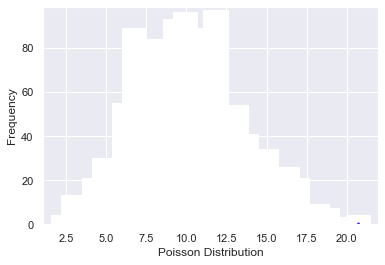

In [59]:
ax = sns.distplot(data_poisson,
                  bins=30,
                  kde=False,
                  color='blue',
                  hist_kws={"linewidth": 15,'alpha':1})
ax.set(xlabel='Poisson Distribution', ylabel='Frequency')

In [116]:
g = nx.Graph()
iso_count = np.zeros(shape=(810))
nodes_per_isobox = [[] for i in range(810)]

for node in range(pop_isoboxes):
    g.add_node(node)
    
    iso_num = np.random.choice(range(810))
    while iso_count[iso_num] == max_pop_per_isobox[iso_num]:
        iso_num = np.random.choice(range(810))
    
    g.nodes[node]["isobox_num"] = iso_num
    iso_count[iso_num] += 1
    
    nodes_per_isobox[iso_num].append(node)


### Add connections between people from the same isobox

In [118]:
import itertools

In [123]:
for node_list in nodes_per_isobox:
    edge_list = [tup for tup in list(itertools.product(node_list, repeat=2)) if tup[0] != tup[1]]
    g.add_edges_from(edge_list)

### Create FRIENDSHIP GRID

In [133]:
# Assumption: people of same node properties interact if they are within close (variable=1) isobox proximity

In [134]:
iso_grid = np.zeros(shape=(29,28))

In [135]:
# At most 8 isobox neghbors if degree = 1, 24 if degree = 2, neighbors= (2*degree+1)^2 - 1
# Access neighbors through formula of degree and grid, connect them using node properties ethnicity and gender

array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0